# Age discrepancy

Now we will try to correlate age discrepancy with some scores of the behavioral dataset. Our model to predict age uses only the structural MRI features.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from utils import create_dataset_mri, cv_for_cde, create_dataset_eeg
from cde.density_estimator import MixtureDensityNetwork
import numpy as np
import tensorflow as tf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.python.keras.activations import tanh
from sklearn.impute import SimpleImputer
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Fix age threshold
threshold = 16

In [3]:
# Behavioral data
behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
# Create dataset MRI
target = 'Age'
data = create_dataset_mri(SCORE = target)

test = data.loc[data['DX_01'].isin(['Autism Spectrum Disorder', 'ADHD-Combined Type', 'ADHD-Inattentive Type', 'Specific Learning Disorder with Impairment in Reading'])]
healthy = data.loc[data['DX_01'].isin(['No Diagnosis Given'])]
train = data.loc[~data['DX_01'].isin(['Autism Spectrum Disorder', 'ADHD-Combined Type', 'ADHD-Inattentive Type', 'No Diagnosis Given', 'Specific Learning Disorder with Impairment in Reading'])]

test = test = test[test['Age']<threshold]
healthy = healthy[healthy['Age']<threshold]
train = train[train['Age']<threshold]


train.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
healthy.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
test.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)



Text(0.5, 1.0, 'Specific Learning Disorder with Impairment in Reading')

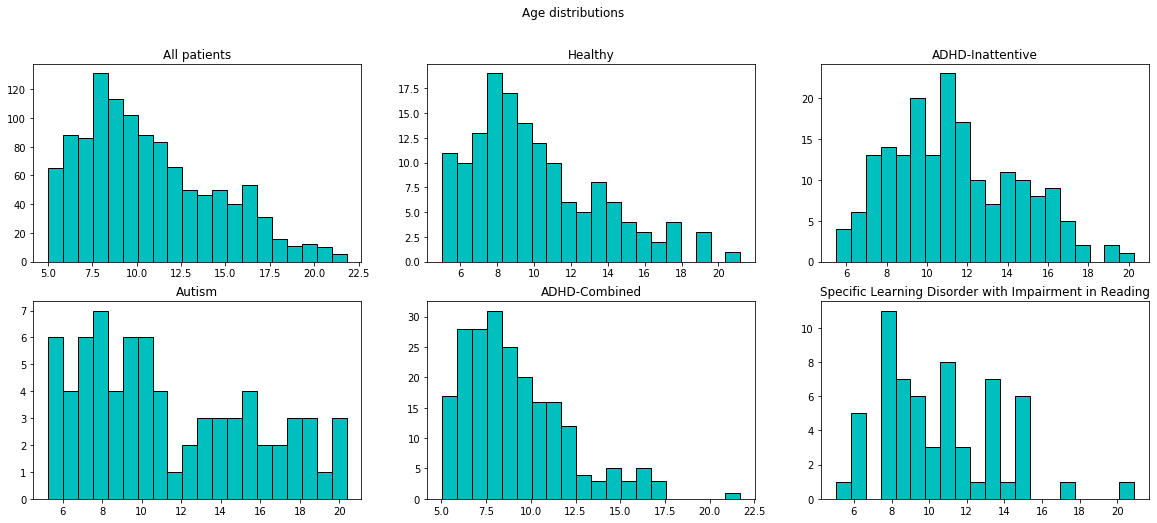

In [4]:
# Visualize distributions
autistics = data[data['DX_01']=='Autism Spectrum Disorder']
combined = data[data['DX_01']=='ADHD-Combined Type']
inattentive = data[data['DX_01']=='ADHD-Inattentive Type']
impaired = data[data['DX_01']=='Specific Learning Disorder with Impairment in Reading']
Healthy = data[data['DX_01']=='No Diagnosis Given']
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 8))
fig.suptitle('Age distributions')
ax1.hist(np.array(data[['Age']]), bins=20, color='c', edgecolor='k')
ax1.set_title('All patients')
ax2.hist(np.array(Healthy[['Age']]), bins=20, color='c', edgecolor='k')
ax2.set_title('Healthy')
ax3.hist(np.array(inattentive[['Age']]), bins=20, color='c', edgecolor='k')
ax3.set_title('ADHD-Inattentive')
ax4.hist(np.array(autistics[['Age']]), bins=20, color='c', edgecolor='k')
ax4.set_title('Autism')
ax5.hist(np.array(combined[['Age']]), bins=20, color='c', edgecolor='k')
ax5.set_title('ADHD-Combined')
ax6.hist(np.array(impaired[['Age']]), bins=20, color='c', edgecolor='k')
ax6.set_title('Specific Learning Disorder with Impairment in Reading')

In [5]:
# train
train = np.array(train)
ID_train_init = train[:,0]
X_train = train[:,2:]
y_train = train[:, 1]
y_train = y_train.reshape((-1,1))

# test
test = np.array(test)
ID_test_init = test[:,0]
X_test = test[:,2:]
y_test = test[:, 1]
y_test = y_test.reshape((-1,1))

# healthy
healthy = np.array(healthy)
y_healthy = healthy[:, 1]
X_healthy = np.concatenate((np.reshape(healthy[:,0],[-1,1]), healthy[:,2:]), axis = 1)
y_healthy = y_healthy.reshape((-1,1))


X_test_init = np.array(X_test, dtype=np.float64)
y_test_init = np.array(y_test, dtype=np.float64)
X_train_init = np.array(X_train, dtype=np.float64)
y_train_init  = np.array(y_train, dtype=np.float64)

# split the healthy
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_healthy, y_healthy, test_size=0.5, random_state=8)
y_train_h = y_train_h.reshape((-1,1))
y_test_h = y_test_h.reshape((-1,1))
ID_train_h = X_train_h[:,0]
X_train_h = X_train_h[:,1:]
ID_test_h = X_test_h[:,0]
X_test_h = X_test_h[:,1:]
y_train_h = np.array(y_train_h, dtype=np.float64)
X_train_h = np.array(X_train_h, dtype=np.float64)
y_test_h = np.array(y_test_h, dtype=np.float64)
X_test_h = np.array(X_test_h, dtype=np.float64)
# Now add again
ID_test = np.concatenate((ID_test_init, ID_test_h))
y_test = np.concatenate((y_test_init, y_test_h))
X_test = np.concatenate((X_test_init, X_test_h))

ID_train = np.concatenate((ID_train_init, ID_train_h))
y_train = np.concatenate((y_train_init, y_train_h))
X_train = np.concatenate((X_train_init, X_train_h))

In [6]:
# Set model parameters
ndim_x=X_train.shape[1]
ndim_y=y_train.shape[1]
# We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
n = X_train.shape[0]
d = X_train.shape[1]+y_train.shape[1]
h = n**(-1/(d+1))
# Define the model
model = MixtureDensityNetwork('MDN', ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
# Fit
model.fit(X_train, y_train)
# Predict
y_pred = model.mean_(X_test)
y_pred = y_pred.reshape((-1,1))
y_pred.shape
print('Test MSE: {}'.format(mean_squared_error(y_pred, y_test)))

1000/1000 [100%] ██████████████████████████████ Elapsed: 9s | loss: 653.036
mean log-loss train: 1.4577
Test MSE: 3.653654595139911


In [7]:
# Define discrepancy
std = model.std_(X_test)
discrepancy = np.divide((y_test-y_pred), std)
#discrepancy = y_test-y_pred

In [8]:
# Get dataframe for test observations with behavioral data + discrepancy
data = {'discrepancy':discrepancy[:,0]}
discrepancy_df = pd.DataFrame(data)
ID_df = pd.DataFrame({'EID':ID_test})
discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
dataframe = dataframe.drop(['Anonymized.ID', 'Study.Site'], axis = 1)

In [9]:
# Get the correlations
correlations = dataframe[dataframe.columns[1:]].corr()['discrepancy'][:]
# Inspect correlations
correlations[correlations > 0.3]  

discrepancy              1.000000
Age                      0.450784
DX_04_New                0.342362
DX_04_Rem                0.320656
sib3dxse                 0.487550
TRF_Pre_Attention_Raw    0.356090
VL_Comm1_Raw             0.570654
VL_Comm_Stnd             0.811083
VL_Social_Scale          0.551015
WIAT_Num_Raw             0.311189
Name: discrepancy, dtype: float64

In [10]:
# Frequencies of major disturb in behavioral dataset
dataframe['DX_01'].value_counts()

ADHD-Combined Type                                       208
ADHD-Inattentive Type                                    172
No Diagnosis Given                                        68
Autism Spectrum Disorder                                  59
Specific Learning Disorder with Impairment in Reading     59
Name: DX_01, dtype: int64

## Consider the most frequent situations: ADHD Inattentive, ADHD Combined, Autism, Healthy. Specific impairment in Reading

In [11]:
df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder', 'Specific Learning Disorder with Impairment in Reading'])]
df = df[df['Age']<threshold]

# Visualization

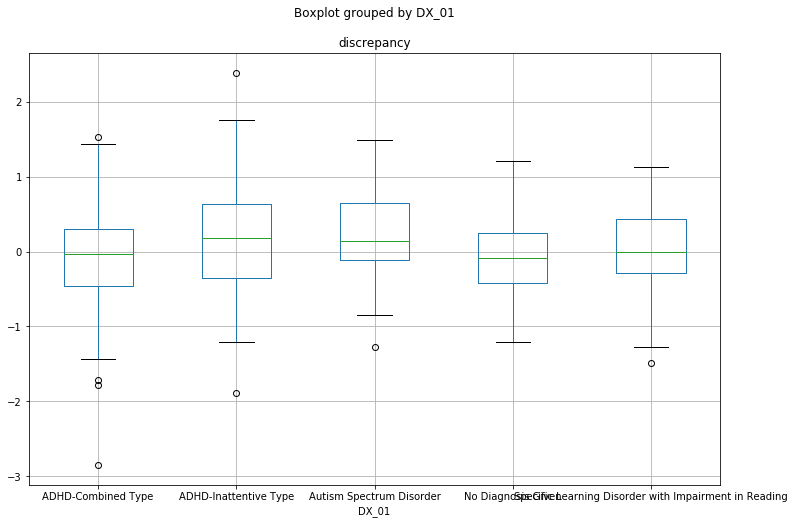

In [12]:
#Create a boxplot
df.boxplot('discrepancy', by='DX_01', figsize=(12, 8))

We got a significant F-test and significant pval for autism.

## Evaluate these quantities as an average over differen splits

In [13]:
def t_test(repetitions, multiple_testing_correction = 'fdr_bh', exclude_old = True, threshold = threshold):
    # Behavioral data
    behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
    # Create dataset MRI
    target = 'Age'
    data = create_dataset_mri(SCORE = target)

    test = data.loc[data['DX_01'].isin(['Autism Spectrum Disorder', 'ADHD-Combined Type', 'ADHD-Inattentive Type', 'Specific Learning Disorder with Impairment in Reading'])]
    healthy = data.loc[data['DX_01'].isin(['No Diagnosis Given'])]
    train = data.loc[~data['DX_01'].isin(['Autism Spectrum Disorder', 'ADHD-Combined Type', 'ADHD-Inattentive Type', 'No Diagnosis Given', 'Specific Learning Disorder with Impairment in Reading'])]
    
    if exclude_old == True:
        # Remove patients aged > threshold
        test = test = test[test['Age']<threshold]
        healthy = healthy[healthy['Age']<threshold]
        train = train[train['Age']<threshold]
    
    
    train.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
    healthy.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
    test.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)

    
    # train
    train = np.array(train)
    ID_train_init = train[:,0]
    X_train = train[:,2:]
    y_train = train[:, 1]
    y_train = y_train.reshape((-1,1))

    # test
    test = np.array(test)
    ID_test_init = test[:,0]
    X_test = test[:,2:]
    y_test = test[:, 1]
    y_test = y_test.reshape((-1,1))

    # healthy
    healthy = np.array(healthy)
    y_healthy = healthy[:, 1]
    X_healthy = np.concatenate((np.reshape(healthy[:,0],[-1,1]), healthy[:,2:]), axis = 1)
    y_healthy = y_healthy.reshape((-1,1))

    
    X_test_init = np.array(X_test, dtype=np.float64)
    y_test_init = np.array(y_test, dtype=np.float64)
    X_train_init = np.array(X_train, dtype=np.float64)
    y_train_init  = np.array(y_train, dtype=np.float64)
    
    # things I want to compute
    t_adhd = []
    t_adhd_combined = []
    t_autism = [] 
    t_impaired = []
    
    for i in range(repetitions):
        # split the healthy
        X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_healthy, y_healthy, test_size=0.5, random_state=i)
        y_train_h = y_train_h.reshape((-1,1))
        y_test_h = y_test_h.reshape((-1,1))
        ID_train_h = X_train_h[:,0]
        X_train_h = X_train_h[:,1:]
        ID_test_h = X_test_h[:,0]
        X_test_h = X_test_h[:,1:]
        y_train_h = np.array(y_train_h, dtype=np.float64)
        X_train_h = np.array(X_train_h, dtype=np.float64)
        y_test_h = np.array(y_test_h, dtype=np.float64)
        X_test_h = np.array(X_test_h, dtype=np.float64)
        # Now add again
        ID_test = np.concatenate((ID_test_init, ID_test_h))
        y_test = np.concatenate((y_test_init, y_test_h))
        X_test = np.concatenate((X_test_init, X_test_h))

        ID_train = np.concatenate((ID_train_init, ID_train_h))
        y_train = np.concatenate((y_train_init, y_train_h))
        X_train = np.concatenate((X_train_init, X_train_h))
    
        # Set model parameters
        ndim_x=X_train.shape[1]
        ndim_y=y_train.shape[1]
        # We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
        n = X_train.shape[0]
        d = X_train.shape[1]+y_train.shape[1]
        h = n**(-1/(d+1))
        model = MixtureDensityNetwork('{}'.format(i), ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
        
        # Fit
        model.fit(X_train, y_train)
        # Predict
        y_pred = model.mean_(X_test)
        y_pred = y_pred.reshape((-1,1))
        # Define discrepancy
        std = model.std_(X_test)
        discrepancy = np.divide((y_test-y_pred), std)
        # Get dataframe for test observations with behavioral data + discrepancy
        data = {'discrepancy':discrepancy[:,0]}
        discrepancy_df = pd.DataFrame(data)
        ID_df = pd.DataFrame({'EID':ID_test})
        discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
        df = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
        
        # t-test for autism vs healthy
        autism = df[df['DX_01'] == 'Autism Spectrum Disorder']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res1 = ttest_ind(np.array(autism), np.array(healthy), equal_var=False)
        
        
        # t-test for inattentive vs healthy
        adhd = df[df['DX_01'] == 'ADHD-Inattentive Type']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res2 = ttest_ind(np.array(adhd), np.array(healthy), equal_var=False)
        
        
        # t-test for combined vs healthy
        combined = df[df['DX_01'] == 'ADHD-Combined Type']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res3 = ttest_ind(np.array(combined), np.array(healthy), equal_var=False)

        # t-test for impaired vs healthy
        impaired = df[df['DX_01'] == 'Specific Learning Disorder with Impairment in Reading']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res4 = ttest_ind(np.array(impaired), np.array(healthy), equal_var=False)
        
        # Correct p-values for multiple-testing
        p_vals = [res1[1], res2[1], res3[1], res4[1]]
        corrected = multipletests(pvals = p_vals, alpha=0.05, method = multiple_testing_correction)
        t_autism.append(corrected[1][0])
        t_adhd.append(corrected[1][1])
        t_adhd_combined.append(corrected[1][2])
        t_impaired.append(corrected[1][3])

        
    print('Mean t-test p-val (inattentive vs healthy): {} \n Mean t-test p-val (combined vs healthy): {} \n Mean t-test p-val (autism vs healthy): {}, \n Mean t-test p-val (impaired vs healthy): {}'.format(np.mean(t_adhd), np.mean(t_adhd_combined), np.mean(t_autism), np.mean(t_impaired)))

In [14]:
t_test(10)

1000/1000 [100%] ██████████████████████████████ Elapsed: 10s | loss: 637.021
mean log-loss train: 1.4219
1000/1000 [100%] ██████████████████████████████ Elapsed: 10s | loss: 638.077
mean log-loss train: 1.4243
1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | loss: 641.496
mean log-loss train: 1.4319
1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | loss: 630.812
mean log-loss train: 1.4081
1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | loss: 658.314
mean log-loss train: 1.4694
1000/1000 [100%] ██████████████████████████████ Elapsed: 12s | loss: 677.927
mean log-loss train: 1.5132
1000/1000 [100%] ██████████████████████████████ Elapsed: 13s | loss: 675.998
mean log-loss train: 1.5089
1000/1000 [100%] ██████████████████████████████ Elapsed: 13s | loss: 635.267
mean log-loss train: 1.4180
1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | loss: 654.783
mean log-loss train: 1.4616
1000/1000 [100%] ██████████████████████████████ Elapsed

Using the Benjamini-Hochberg correction.